## Visualize heatmaps of differentially expressed genes

Visualize a heatmap of the differentially expressed genes using the original E-GEOD-51409 expression data versus the simulated expression data for the same experiment

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import random
import glob
from sklearn import preprocessing

from ponyo import utils
from simulate_expression_compendia_modules import generate_labeled_data

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/simulate_expression_compendia/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
config_file = os.path.abspath(os.path.join(os.getcwd(),"../configs", "config_Pa_experiment_limma.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
experiment_id = 'E-GEOD-51409'

base_dir = os.path.abspath(
  os.path.join(
      os.getcwd(), "../"))

In [4]:
# Input files
# File containing expression data from template experiment
selected_original_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_original_data_"+experiment_id+"_example.txt")

selected_compressed_only_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_compressed_only_data_"+experiment_id+"_example.txt")

selected_simulated_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+experiment_id+"_example.txt")

selected_control_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_control_data_"+experiment_id+"_example.txt")

# Files containing DE summary statistics
DE_stats_original_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_original",
    "DE_stats_original_data_"+experiment_id+"_example.txt")

DE_stats_compressed_only_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_original",
    "DE_stats_compressed_only_data_"+experiment_id+"_example.txt")

DE_stats_simulated_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_simulated",
    "DE_stats_simulated_data_"+experiment_id+"_example.txt")

DE_stats_control_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_control",
    "DE_stats_control_data_"+experiment_id+"_example.txt")

# Gene number to gene name file
gene_name_file = os.path.join(
    base_dir,
    "Pseudo_experiments",
    "Pseudomonas_aeruginosa_PAO1_107.csv")

In [5]:
# Output files
heatmap_original_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_original_"+experiment_id+"_example.svg")

heatmap_compressed_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_compressed_only_"+experiment_id+"_example.svg")

heatmap_simulated_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_simulated_"+experiment_id+"_example.svg")

heatmap_control_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_control_"+experiment_id+"_example.svg")

corr_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "corr_gene_logFC_"+experiment_id+"_example.svg")

original_sign_DEG_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "sign_DEG_original_"+experiment_id+"_example.txt")

simulated_sign_DEG_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "sign_DEG_simulated_"+experiment_id+"_example.txt")

control_sign_DEG_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "sign_DEG_control_"+experiment_id+"_example.txt")

In [6]:
# Read data
selected_original_data = pd.read_csv(
    selected_original_data_file,
    header=0,
    sep='\t',
    index_col=0)

selected_compressed_only_data = pd.read_csv(
    selected_compressed_only_data_file,
    header=0,
    sep='\t',
    index_col=0)

selected_simulated_data = pd.read_csv(
    selected_simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

selected_control_data = pd.read_csv(
    selected_control_data_file,
    header=0,
    sep='\t',
    index_col=0)


DE_stats_original_data = pd.read_csv(
    DE_stats_original_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_compressed_only_data = pd.read_csv(
    DE_stats_compressed_only_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_simulated_data = pd.read_csv(
    DE_stats_simulated_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_control_data = pd.read_csv(
    DE_stats_control_file,
    header=0,
    sep='\t',
    index_col=0)

In [7]:
# Experiment-perserving-simulated experiment
# Get DEGs to display in heatmap
# Get the number of genes that adjusted p-value < 0.05 AND log2FC > 1

sign_DEG_simulated = DE_stats_simulated_data[
    (abs(DE_stats_simulated_data['logFC'])>1) & (DE_stats_simulated_data['adj.P.Val']<0.05)]
print(sign_DEG_simulated.shape[0])

# Sort significant DEGs and select top 30 genes
sign_DEG_simulated.sort_values(by=['adj.P.Val'])
sign_DEG_simulated = sign_DEG_simulated.iloc[0:30,]

sign_DEG_simulated.to_csv(
        simulated_sign_DEG_file, float_format='%.3f', sep='\t')

sign_DEG_simulated.head(10)

14


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4881,1.186667,6.110333,76.929079,4.912461e-11,8.693838e-08,16.271234
PA3126,1.008333,10.002167,67.210999,1.201542e-10,8.693838e-08,15.480725
PA1970,1.210000,6.100000,65.931078,1.364684e-10,8.693838e-08,15.364311
PA0896,-1.088333,8.500833,-53.982611,5.126838e-10,9.324276e-08,14.104194
PA2007,-1.213667,10.253833,-51.882139,6.666451e-10,1.109186e-07,13.844522
PA0865,-1.072333,9.780833,-51.497054,7.003267e-10,1.110318e-07,13.795465
PA5470,1.072333,7.252833,42.450286,2.512564e-09,1.640261e-07,12.492885
PA2008,-1.077000,10.449833,-39.991793,3.726671e-09,1.863276e-07,12.080373
PA2006,-1.168667,8.953333,-29.298450,2.902353e-08,4.421157e-07,9.873339
PA4354,1.149667,6.347167,26.432893,5.713547e-08,6.359023e-07,9.128563


In [8]:
# Original experiment
# Get DEGs to display in heatmap
# Get the number of genes that adjusted p-value < 0.05 and log2FC > 1

sign_DEG_original = DE_stats_original_data[
    (abs(DE_stats_original_data['logFC'])>1) & (DE_stats_original_data['adj.P.Val']<0.05)]
print(sign_DEG_original.shape[0])

# Sort significant DEGs and select top 14 genes to be consistent with experiment-level simulation
sign_DEG_original.sort_values(by=['adj.P.Val'])
sign_DEG_original = sign_DEG_original.iloc[0:14,]


sign_DEG_original.to_csv(
        original_sign_DEG_file, float_format='%.3f', sep='\t')

sign_DEG_original.head(10)

505


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4175,-4.156000,10.562667,-42.035258,6.313727e-12,3.503487e-08,17.540678
PA0887,5.272667,9.499667,38.232066,1.518100e-11,4.211970e-08,16.849060
PA1914,-3.426667,9.025333,-32.831680,6.197397e-11,1.037664e-07,15.666580
PA0534,-3.213000,9.886167,-32.169062,7.480010e-11,1.037664e-07,15.502182
PA4648,-3.226000,10.733667,-31.139338,1.009716e-10,1.120582e-07,15.237142
PA3234,3.262667,8.826333,28.785259,2.083130e-10,1.926549e-07,14.583768
PA1245,2.901667,9.017500,28.003063,2.684290e-10,2.018870e-07,14.350732
PA1432,2.773000,9.649500,27.587966,3.079593e-10,2.018870e-07,14.223583
PA2939,-2.783667,10.368167,-27.258658,3.439175e-10,2.018870e-07,14.120936
PA0899,-3.250000,8.995000,-27.092334,3.638259e-10,2.018870e-07,14.068482


In [9]:
# VAE compressed-only experiment
# Get DEGs to display in heatmap
# Get the number of genes that adjusted p-value < 0.05 and log2FC > 1

sign_DEG_compressed = DE_stats_compressed_only_data[
    (abs(DE_stats_compressed_only_data['logFC'])>1) & (DE_stats_compressed_only_data['adj.P.Val']<0.05)]
print(sign_DEG_compressed.shape[0])

# Sort significant DEGs and select top 14 genes
sign_DEG_compressed.sort_values(by=['adj.P.Val'])
sign_DEG_compressed = sign_DEG_compressed.iloc[0:14,]

sign_DEG_compressed.head(10)

78


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA1714,1.305803,9.124458,114.828974,1.285488e-13,5.139723e-10,21.939443
PA4220,1.341706,9.079394,109.449584,1.852486e-13,5.139723e-10,21.636414
PA1894,-1.497256,7.670223,-98.543493,4.119884e-13,6.704161e-10,20.947612
PA0887,1.813950,10.699308,96.446595,4.852990e-13,6.704161e-10,20.802348
PA1245,1.039451,9.781711,93.174158,6.311780e-13,6.704161e-10,20.566456
PA1895,-1.384747,8.074383,-91.495099,7.249047e-13,6.704161e-10,20.440859
PA4221,1.121977,8.220158,88.065916,9.695798e-13,7.052949e-10,20.174153
PA0897,-1.290867,7.465443,-85.601846,1.203396e-12,7.052949e-10,19.973585
PA0899,-1.580961,8.523615,-83.977494,1.392341e-12,7.052949e-10,19.837056
PA5212,-1.341988,9.602885,-83.931702,1.398134e-12,7.052949e-10,19.833156


In [10]:
# Randomly-sampled-simulated experiment
# Get DEGs to display in heatmap
# Get the number of genes that adjusted p-value < 0.05 AND log2FC > 1

sign_DEG_control = DE_stats_control_data[
    (abs(DE_stats_control_data['logFC'])>1) & (DE_stats_control_data['adj.P.Val']<0.05)]
print(sign_DEG_control.shape[0])

if sign_DEG_control.shape[0] == 0:
    # Reset data
    sign_DEG_control = DE_stats_control_data
    
    # Sort significant DEGs and select top 14 genes
    sign_DEG_control.sort_values(by=['adj.P.Val'])
    sign_DEG_control = sign_DEG_control.iloc[0:14,]

sign_DEG_control.to_csv(
        control_sign_DEG_file, float_format='%.3f', sep='\t')

sign_DEG_control.head(10)

0


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4940,0.886000,8.753667,5.192414,0.000378,0.756151,-2.817878
PA3327,-0.702000,8.331000,-4.947938,0.000543,0.756151,-2.884574
PA0997,-1.435667,9.155833,-4.871035,0.000610,0.756151,-2.906649
PA1903,-1.015000,8.529833,-4.572223,0.000966,0.756151,-2.997696
PA4762,-0.954667,9.951667,-4.525032,0.001040,0.756151,-3.012871
PA4385,-1.011000,11.089167,-4.524356,0.001041,0.756151,-3.013090
PA0802,0.869000,6.556167,4.444968,0.001179,0.756151,-3.039131
PA4211,-1.564333,8.613833,-4.354401,0.001361,0.756151,-3.069629
PA2194,-1.024000,8.614333,-4.343709,0.001384,0.756151,-3.073285
PA1774,0.660333,7.531167,4.138164,0.001924,0.756151,-3.145943


In [11]:
# Get gene ids for significant DEGs
original_gene_ids = list(sign_DEG_original.index)
compressed_gene_ids = list(sign_DEG_compressed.index)
sim_gene_ids = list(sign_DEG_simulated.index)
control_gene_ids = list(sign_DEG_control.index)

In [12]:
# Read gene number to name mapping
gene_name_mapping = pd.read_table(
    gene_name_file,
    header=0,
    sep=',',
    index_col=0)

gene_name_mapping = gene_name_mapping[["Locus Tag", "Name"]]

gene_name_mapping.set_index("Locus Tag", inplace=True)
gene_name_mapping.head()

/home/alexandra/anaconda3/envs/simulate_expression_compendia/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


,Name
Locus Tag,
"PA0001""",dnaA
"PA0002""",dnaN
"PA0003""",recF
"PA0004""",gyrB
"PA0005""",lptA


In [13]:
# Format gene numbers to remove extraneous quotes
gene_number = gene_name_mapping.index
gene_name_mapping.index = gene_number.str.strip("\"")

gene_name_mapping.head()

,Name
Locus Tag,
PA0001,dnaA
PA0002,dnaN
PA0003,recF
PA0004,gyrB
PA0005,lptA


In [14]:
# Map gene numbers to names
def get_gene_names(gene_id_list):    
    gene_names = []
    for gene_id in gene_id_list:
        gene_name = gene_name_mapping.loc[gene_id]
        if gene_name.isnull()[0]:
            # If gene name does not exist
            # Use gene number
            gene_names.append(gene_id)
        else:
            gene_names.append(gene_name[0])
    return gene_names

In [15]:
original_gene_names = get_gene_names(original_gene_ids)
compressed_gene_names = get_gene_names(compressed_gene_ids)
control_gene_names = get_gene_names(control_gene_ids)
sim_gene_names = get_gene_names(sim_gene_ids)

print(original_gene_names)
print(control_gene_names)
print(sim_gene_ids)

['piv', 'acsA', 'PA1914', 'pauB1', 'cupE1', 'PA3234', 'aprX', 'lasI', 'PA2939', 'aruB', 'gapA', 'PA0535', 'PA1875', 'aruG']
['PA4940', 'PA3327', 'pqsB', 'phzE2', 'grpE', 'groEL', 'PA0802', 'phzB1', 'hcnB', 'crfX', 'arcC', 'dchB', 'pqsC', 'gdhB']
['PA4881', 'PA3126', 'PA1970', 'PA0896', 'PA2007', 'PA0865', 'PA5470', 'PA2008', 'PA2006', 'PA4354', 'PA4182', 'PA1999', 'PA1337', 'PA0899']


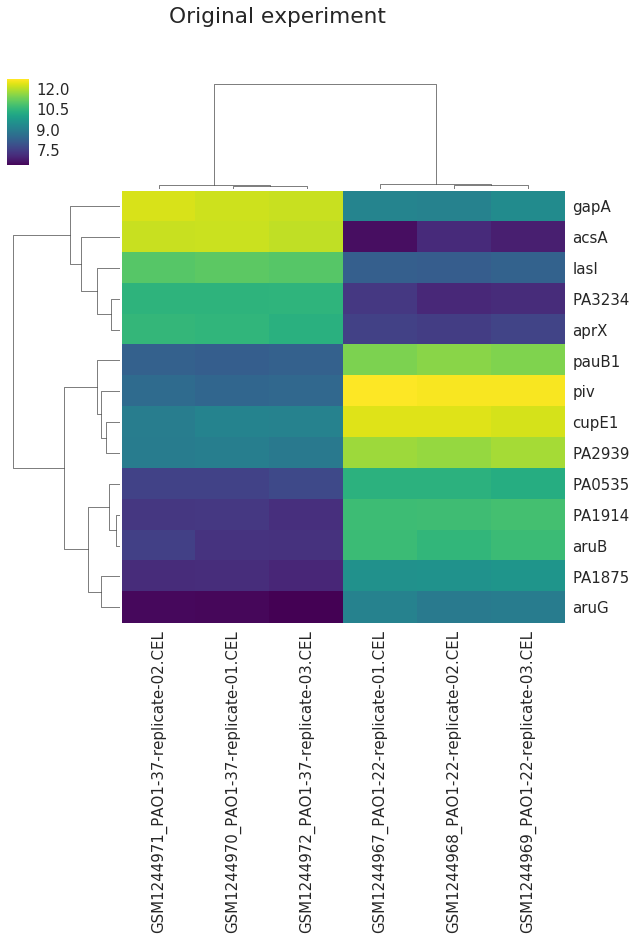

In [16]:
# Plot original data
selected_original_DEG_data = selected_original_data[original_gene_ids]
selected_original_DEG_data.columns = original_gene_names
sns.set(style="ticks", context="talk")
sns.set(font='sans-serif', font_scale=1.5)
f = sns.clustermap(selected_original_DEG_data.T, cmap="viridis")
f.fig.suptitle('Original experiment') 
f.savefig(heatmap_original_file)

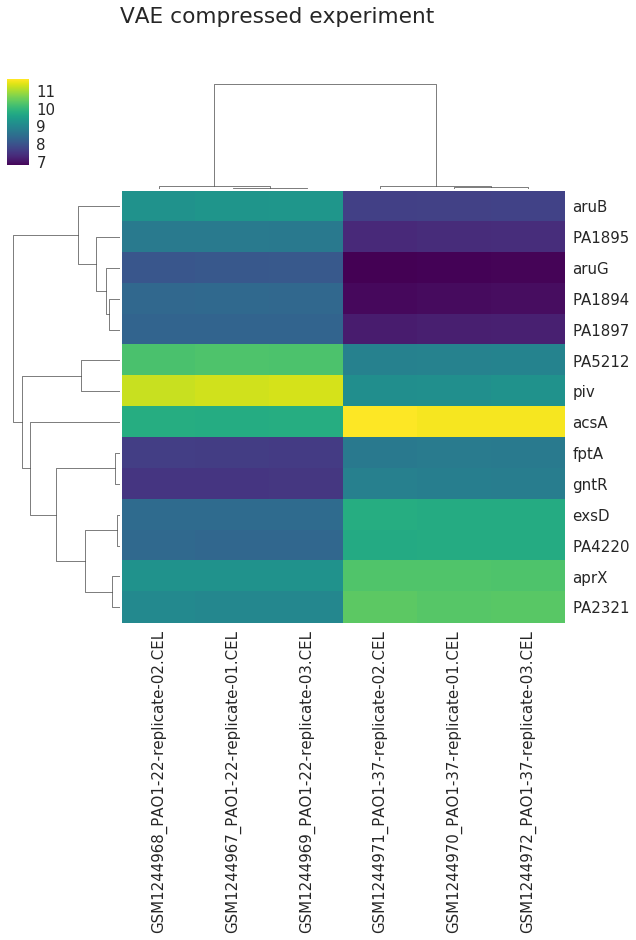

In [17]:
# Plot compressed data
selected_compressed_DEG_data = selected_compressed_only_data[compressed_gene_ids]
selected_compressed_DEG_data.columns = compressed_gene_names
sns.set(style="ticks", context="talk")
sns.set(font='sans-serif', font_scale=1.5)
f = sns.clustermap(selected_compressed_DEG_data.T, cmap="viridis")
f.fig.suptitle('VAE compressed experiment') 
f.savefig(heatmap_compressed_file)

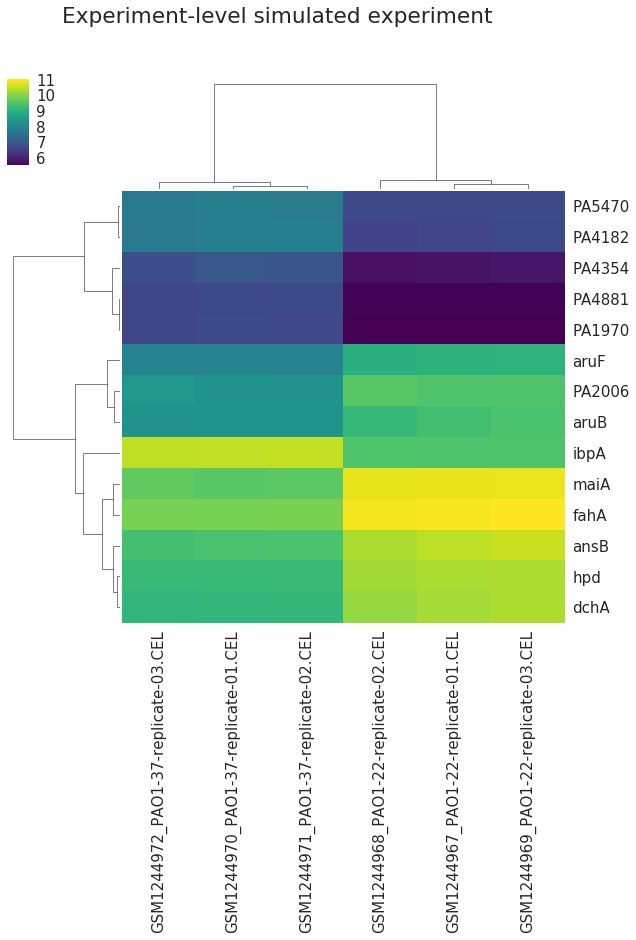

In [18]:
# Plot simulated
selected_simulated_DEG_data = selected_simulated_data[sim_gene_ids]
selected_simulated_DEG_data.columns = sim_gene_names
sns.set(font='sans-serif', font_scale=1.5)
f = sns.clustermap(selected_simulated_DEG_data.T, cmap="viridis")
f.fig.suptitle('Experiment-level simulated experiment') 
f.savefig(heatmap_simulated_file)

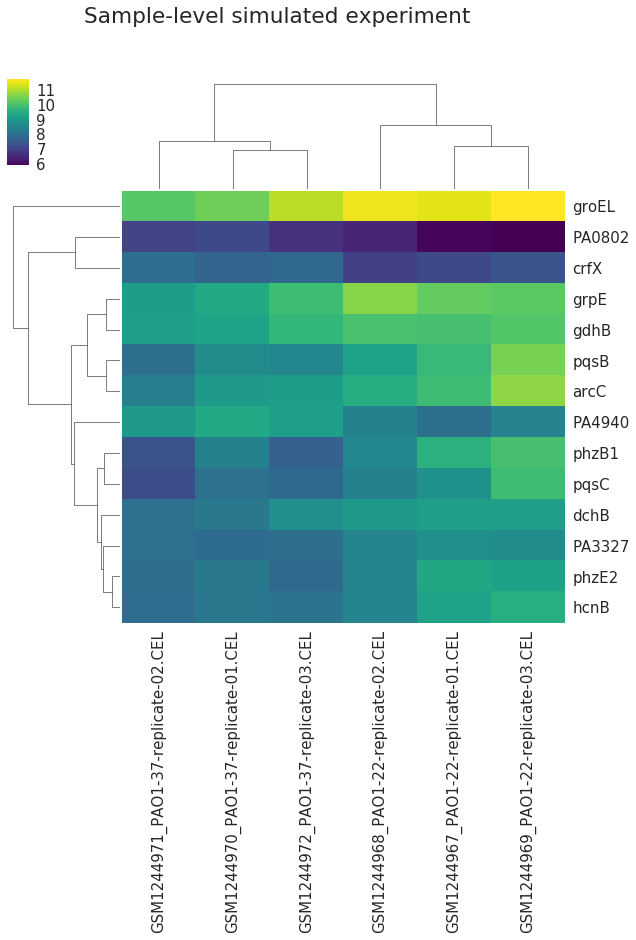

In [19]:
# Plot control
selected_control_DEG_data = selected_control_data[control_gene_ids]
selected_control_DEG_data.columns = control_gene_names
sns.set(font='sans-serif', font_scale=1.5)
f = sns.clustermap(selected_control_DEG_data.T, cmap="viridis")
f.fig.suptitle('Sample-level simulated experiment') 
f.savefig(heatmap_control_file)

**Summary**
The heatmaps display the top differentially expressed genes (FDR adj p-value < 0.05 and log2 FC > 1) identified using the original expression data (```selected_original_DEG_data```), using simulated expression data created by randomly sampling the compendium (```selected_control_DEG_data```), using the simulated expression data created by sampling by experiment from compendium (```selected_simulated_DEG_data```).

The heatmaps show that the samples are clustered the same between the original experiment versus the simulated experiment generating using the experiment-preserving approach (```selected_simulated_DEG_data```). This indicates that the VAE, which was used to simulate data, is able to capture and preserve the design of the experiment. However, the there is a difference between the set of DEGs identified in the original versus the simulated experiment, indicating the creation of a “new” experiment.  This new experiment can be used as a hypothesis generating tool - to allow us to explore novel untested experimental stimuli

The heatmaps also show that the sample clustering is *not* consistent between the simulated experiment generated using the experiment preserving approach (```selected_simulated_DEG_data``` generated by ```generate_E_GEOD_51409_template_experiment.ipynb```) and the simulated experiment generated using the random sampling approach (```selected_control_DEG_data``` generated by ```generate_random_sampled_experiment.ipynb```). This indicates that our added complexity of simulating at the experiment-level compared to the sample-level is more representative of true expression data.
 

## Compare gene ranks

In [20]:
gene_stats = DE_stats_original_data.join(DE_stats_compressed_only_data['logFC'], rsuffix='_vae_compressed')[['logFC', 'logFC_vae_compressed']]
gene_stats = gene_stats.join(DE_stats_simulated_data['logFC'], rsuffix='_experiment_lvl')
gene_stats = gene_stats.join(DE_stats_control_data['logFC'], rsuffix='_sample_lvl')

gene_stats.head()

,logFC,logFC_vae_compressed,logFC_experiment_lvl,logFC_sample_lvl
PA4175,-4.156000,-2.082470,-0.484333,-0.411667
PA0887,5.272667,1.813950,-0.041667,-0.597667
PA1914,-3.426667,-2.193806,-0.293000,0.239667
PA0534,-3.213000,-0.968050,-0.038000,-0.150000
PA4648,-3.226000,-1.665311,-0.402667,-0.010667


In [21]:
# Get within sample correlation
gene_stat_corr = gene_stats.corr()
gene_stat_corr.columns = ['original experiment',
                         'VAE compressed experiment',
                         'Experiment-level simulated experiment',
                         'Sample-level simulated experiment']
gene_stat_corr.index = ['original experiment',
                         'VAE compressed experiment',
                         'Experiment-level simulated experiment',
                         'Sample-level simulated experiment']
gene_stat_corr

,original experiment,VAE compressed experiment,Experiment-level simulated experiment,Sample-level simulated experiment
original experiment,1.000000,0.822066,0.230413,-0.054957
VAE compressed experiment,0.822066,1.000000,0.330977,-0.118857
Experiment-level simulated experiment,0.230413,0.330977,1.000000,0.078071
Sample-level simulated experiment,-0.054957,-0.118857,0.078071,1.000000


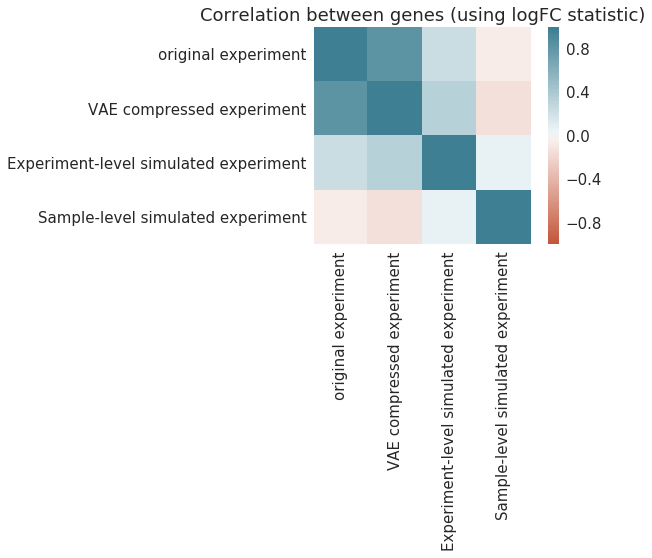

In [22]:
f = sns.heatmap(
    gene_stat_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
f.set_title("Correlation between genes (using logFC statistic)")
f.figure.savefig(corr_file)